In [1]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.7 MB/s eta 0:00:00


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import make_pipeline

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

In [5]:
df = df.drop(["customerID"],axis=1)

In [6]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [8]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

In [11]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)
pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

In [20]:
cv = StratifiedKFold(n_splits=15)

param_grid = {
    "n_neighbors": [11, 13, 15, 17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="recall")
grid_search.fit(X_train_res_pca, y_train_res)

best_knn = grid_search.best_estimator_

In [21]:
y_pred = best_knn.predict(X_test_pca)

accuracy = accuracy_score(y_test_sm, y_pred)
recall = recall_score(y_test_sm, y_pred)
f1 = f1_score(y_test_sm, y_pred)
conf_matrix = confusion_matrix(y_test_sm, y_pred)
class_report = classification_report(y_test_sm, y_pred)

print("=====================================")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Best Parameters:", grid_search.best_params_)
print("=====================================")

Accuracy: 0.7170616113744076
Recall: 0.7415329768270945
F1 Score: 0.5822253324002798
Confusion Matrix:
 [[1097  452]
 [ 145  416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.72      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.78      0.72      0.73      2110

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


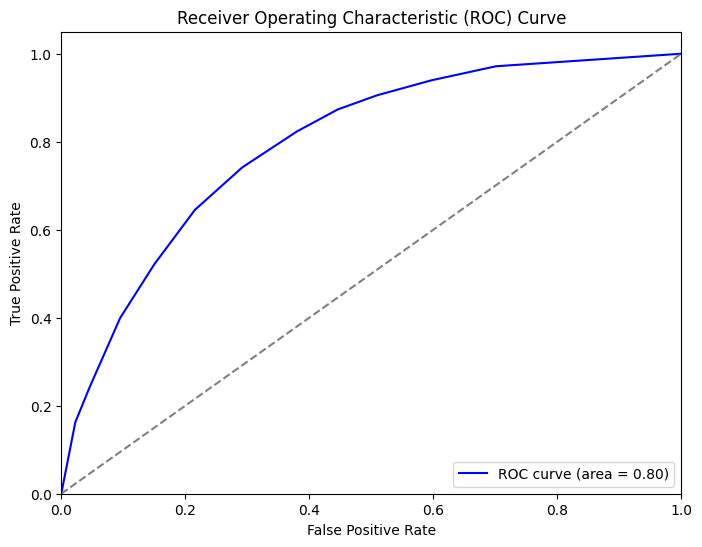

In [22]:
y_pred_prob = best_knn.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test_sm, y_pred_prob)
roc_auc = roc_auc_score(y_test_sm, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=11, metric="manhattan", weights="uniform")

knn.fit(X_train_res_pca, y_train_res)

y_pred_sm = knn.predict(X_test_pca)

recall = recall_score(y_test_sm, y_pred_sm)
f1 = f1_score(y_test_sm, y_pred_sm)
conf_matrix = confusion_matrix(y_test_sm, y_pred_sm)
class_report = classification_report(y_test_sm, y_pred_sm)

print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Recall Score: 0.7415329768270945
F1 Score: 0.5822253324002798
Confusion Matrix:
[[1097  452]
 [ 145  416]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1549
           1       0.48      0.74      0.58       561

    accuracy                           0.72      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.78      0.72      0.73      2110



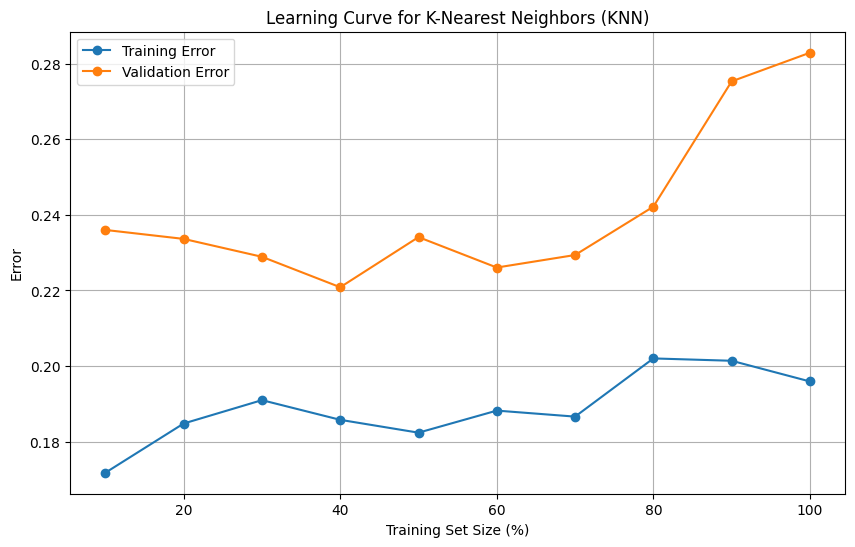

In [24]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for train_size in train_sizes:
    subset_size = int(train_size * len(X_train_res_pca))
    X_train_subset = X_train_res_pca[:subset_size]
    y_train_subset = y_train_res[:subset_size]

    knn = KNeighborsClassifier(n_neighbors=11, metric="manhattan", weights="uniform")
    knn.fit(X_train_subset, y_train_subset)

    y_train_pred = knn.predict(X_train_subset)
    train_error = 1 - accuracy_score(y_train_subset, y_train_pred)
    train_errors.append(train_error)

    y_test_pred = knn.predict(X_test_pca)
    val_error = 1 - accuracy_score(y_test_sm, y_test_pred)
    val_errors.append(val_error)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes * 100, val_errors, label='Validation Error', marker='o')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Error')
plt.title('Learning Curve for K-Nearest Neighbors (KNN)')
plt.legend()
plt.grid()
plt.show()